In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, classification_report, recall_score, precision_score, roc_curve, precision_recall_curve, \
                            average_precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.inspection import permutation_importance
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

!pip install xgboost
from xgboost import XGBClassifier

In [2]:
        # Import xlsx as DataFrame and inspect (https://www.ibm.com/docs/en/cognos-analytics/11.2.x?topic=samples-telco-customer-churn)

df = pd.read_excel('Telco_customer_churn.xlsx')

churn_df = df.copy()

print(churn_df.head(10))
print(churn_df.columns)

   CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   
3  7892-POOKP      1  United States  California  Los Angeles     90010   
4  0280-XJGEX      1  United States  California  Los Angeles     90015   
5  4190-MFLUW      1  United States  California  Los Angeles     90020   
6  8779-QRDMV      1  United States  California  Los Angeles     90022   
7  1066-JKSGK      1  United States  California  Los Angeles     90024   
8  6467-CHFZW      1  United States  California  Los Angeles     90028   
9  8665-UTDHZ      1  United States  California  Los Angeles     90029   

                 Lat Long   Latitude   Longitude  Gender  ...        Contract  \
0  33.964131, -118.272783  33.964131 -118.272783    Male  ...  Month-to-month   
1   34.059281, -118.307

In [3]:
        # EDA

print(churn_df.shape)
print(churn_df.describe())
print(churn_df.info())
print(churn_df.isna().sum())

(7043, 33)
        Count      Zip Code     Latitude    Longitude  Tenure Months  \
count  7043.0   7043.000000  7043.000000  7043.000000    7043.000000   
mean      1.0  93521.964646    36.282441  -119.798880      32.371149   
std       0.0   1865.794555     2.455723     2.157889      24.559481   
min       1.0  90001.000000    32.555828  -124.301372       0.000000   
25%       1.0  92102.000000    34.030915  -121.815412       9.000000   
50%       1.0  93552.000000    36.391777  -119.730885      29.000000   
75%       1.0  95351.000000    38.224869  -118.043237      55.000000   
max       1.0  96161.000000    41.962127  -114.192901      72.000000   

       Monthly Charges  Churn Value  Churn Score         CLTV  
count      7043.000000  7043.000000  7043.000000  7043.000000  
mean         64.761692     0.265370    58.699418  4400.295755  
std          30.090047     0.441561    21.525131  1183.057152  
min          18.250000     0.000000     5.000000  2003.000000  
25%          35.5000

In [4]:
        # Feature Engineering

    ## Dropping useless (in this case) features

drop_cols = [
    "CustomerID", "Count", "Country", "State", "City",
    "Zip Code", "Lat Long", "Latitude", "Longitude",    #    Not going to perform geo clustering so not needed
    "Churn Label", "Churn Reason", "Churn Score"    # DATA LEAKAGE
]

churn_df = churn_df.drop(columns=drop_cols, errors='ignore')

    ## Creating new features, fixing other features

binary_cols = [
    "Partner", "Dependents", 'Senior Citizen',
    "Phone Service", "Paperless Billing"              # Fix binary columns (VERY IMPORTANT)
]

for col in binary_cols:
    churn_df[col] = churn_df[col].map({"Yes": 1, "No": 0})    

churn_df["Total Charges"] = pd.to_numeric(churn_df["Total Charges"], errors="coerce")    #Changing str to num

churn_df["Charges_per_Month"] = churn_df["Total Charges"] / (churn_df["Tenure Months"] + 1)    # Spending Intensity

churn_df["Is_New"] = (churn_df["Tenure Months"] < 6).astype(int)    # New customers
churn_df["Is_Loyal"] = (churn_df["Tenure Months"] > 24).astype(int)    # Loyal customers

service_cols = [
    'Phone Service','Multiple Lines','Internet Service',
    'Online Security','Online Backup','Device Protection',    # Service features
    'Tech Support','Streaming TV','Streaming Movies'
]

churn_df["Num_Services"] = (churn_df[service_cols] == "Yes").sum(axis=1)    #Service count

print(churn_df["Num_Services"].head())
print(churn_df.columns)
print(churn_df.describe())
print(churn_df.info())

0    2
1    0
2    4
3    5
4    5
Name: Num_Services, dtype: int64
Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
       'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Value',
       'CLTV', 'Charges_per_Month', 'Is_New', 'Is_Loyal', 'Num_Services'],
      dtype='object')
       Senior Citizen      Partner   Dependents  Tenure Months  Phone Service  \
count     7043.000000  7043.000000  7043.000000    7043.000000    7043.000000   
mean         0.162147     0.483033     0.231010      32.371149       0.903166   
std          0.368612     0.499748     0.421508      24.559481       0.295752   
min          0.000000     0.000000     0.000000       0.000000       0.000000   
25%          0.000000     0.000000     0.000000       9.000

<Axes: xlabel='Churn Value'>

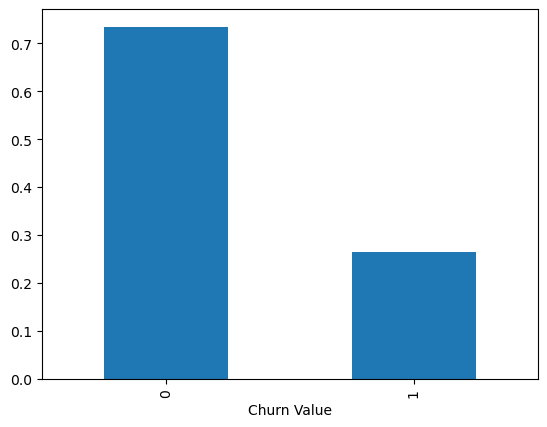

In [5]:
churn_df["Churn Value"].value_counts(normalize=True).plot(kind="bar")

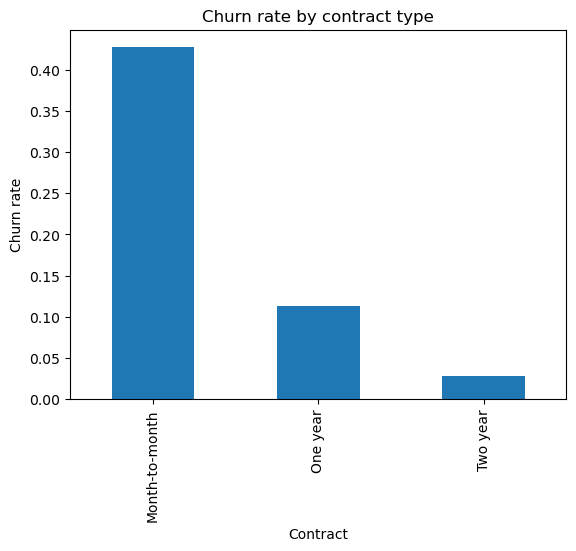

In [6]:
rates = pd.crosstab(
    churn_df["Contract"],
    churn_df["Churn Value"],
    normalize="index"
)[1]

rates.plot(kind="bar")
plt.ylabel("Churn rate")
plt.title("Churn rate by contract type")
plt.show()

In [7]:
        # Defining target, and dividing features by type

target = 'Churn Value'

    ## Defining train-test split
X = churn_df.drop(target, axis=1)    # FEATURES
y = churn_df[target]                 # TARGET (Churn)

SEED = 619
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y, test_size =0.2, random_state =SEED)    # 80% TRAIN, 20% TEST

    ## Create num_features and cat_features for a ColumnTransformer for numeric and categorical features
num_features = X.select_dtypes(include='number').columns
cat_features = X.select_dtypes(exclude='number').columns
print(num_features, cat_features)


num_features = [
    'Tenure Months', 'Monthly Charges', 'Total Charges',    # NUMERICAL
    'Charges_per_Month', 'CLTV', 'Num_Services'
]

binary_features = [
    'Senior Citizen', 'Partner', 'Dependents',    # BINARY
    'Phone Service', 'Paperless Billing',
    'Is_New', 'Is_Loyal'
]

cat_features = [
    'Gender', 'Multiple Lines', 'Internet Service',
    'Online Security', 'Online Backup', 'Device Protection',    # CATEGORICAL
    'Tech Support', 'Streaming TV', 'Streaming Movies',
    'Contract', 'Payment Method'
]

        # Creating ColumnTransformer preprocessor

preprocessor = ColumnTransformer([
    ("num_features", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),    # Impute with median and StandarScaler for NUMERICAL values
        ("scaler", StandardScaler())
    ]), num_features),

    ("binary_features", SimpleImputer(strategy="most_frequent"), binary_features),    # Impute binaries with the most frequent value

    ("cat_features", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),    # Impute categoricals with most frequent, and encode for models
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_features)
])

Index(['Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
       'Phone Service', 'Paperless Billing', 'Monthly Charges',
       'Total Charges', 'CLTV', 'Charges_per_Month', 'Is_New', 'Is_Loyal',
       'Num_Services'],
      dtype='object') Index(['Gender', 'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Payment Method'],
      dtype='object')


In [8]:
        # Finding best params for XGBClassifier and RandomForest with RandomizedSearchCV (Logistic wont be tuned)

    ## XGBClassifier pipeline and best estimator

ratio = len(y_train[y_train==0]) / len(y_train[y_train==1])

xgb_pipe = ImbPipeline([
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=SEED, sampling_strategy=0.5)),
    ("xgbmodel", XGBClassifier(
        random_state=SEED,
        eval_metric="logloss",
        scale_pos_weight=ratio,
    ))
])

    ## XGBClassifier Grid    

param_dist_xgb = {
    "xgbmodel__n_estimators": [200, 300, 400],
    "xgbmodel__max_depth": [3, 5, 8],
    "xgbmodel__learning_rate": [0.05, 0.1, 0.2],
    "xgbmodel__subsample": [0.8, 1.0],
    "xgbmodel__colsample_bytree": [0.8, 1.0]
}

    ## Instantiating RandomizedSearchCV to find the best hyperparameters

xgb_rsearch = RandomizedSearchCV(
    xgb_pipe,
    param_distributions=param_dist_xgb,
    n_iter=10,
    scoring="average_precision",    # Use average_precision because churn is imbalanced and probability-based, not a simple binary decision.
    cv=5,
    n_jobs=-1,
    random_state=SEED,
    verbose=2
)

xgb_rsearch.fit(X_train, y_train)

best_xgb = xgb_rsearch.best_estimator_
print(best_xgb)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\primo\Code_P9\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\primo\Code_P9\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\primo\Code_P9\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\primo\Code_P9\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Tenure Months',
                                                   'Monthly Charges',
                                                   'Total Charges',
                                                   'Charges_per_Month', 'CLTV',
                                                   'Num_Services']),
                                                 ('binary_features',
                                                  SimpleImputer(strategy='most_frequent'),
                                           

In [9]:
        # Finding best parameters for RandomForest

    ## Creating RF Pipeline with preprocessor and models


rf_pipe = ImbPipeline([
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=SEED, sampling_strategy=0.5)),
    ("rfmodel", RandomForestClassifier(random_state=SEED, class_weight='balanced', n_jobs=-1))
])

    ## RandomForest Grid

param_dist_rf = {
    'rfmodel__n_estimators': [200, 400, 600],
    'rfmodel__max_depth': [5, 10, 20, 30],
    'rfmodel__min_samples_split': [2, 5, 10],
    'rfmodel__min_samples_leaf': [1, 2, 4]
}

    ## Instantiating RandomizedSearchCV to find the best hyperparameters

rf_rsearch = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist_rf,
    n_iter=10,
    scoring='average_precision',    # Use average_precision because churn is imbalanced and probability-based, not a simple binary decision.
    cv=5,
    n_jobs=-1,
    random_state=SEED,
    verbose=2
)

rf_rsearch.fit(X_train, y_train)
best_rf = rf_rsearch.best_estimator_
print(best_rf)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Tenure Months',
                                                   'Monthly Charges',
                                                   'Total Charges',
                                                   'Charges_per_Month', 'CLTV',
                                                   'Num_Services']),
                                                 ('binary_features',
                                                  SimpleImputer(strategy=

In [10]:
        # Creating lr pipelina and instantiating StackingClassifier

    ## Creating estimators and making a StackingCassifier

lr_pipe = ImbPipeline([
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=SEED, sampling_strategy=0.5)),
    ("model", LogisticRegression(max_iter=1000, class_weight='balanced'))
])

estimators = [
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('lr', lr_pipe)
]

stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    stack_method='predict_proba',
    cv=5,
    n_jobs=-1,
    verbose=2
)

stack.fit(X_train, y_train)

y_pred = stack.predict(X_test)
y_proba = stack.predict_proba(X_test)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

ROC-AUC: 0.8863261773747708
              precision    recall  f1-score   support

           0       0.86      0.91      0.89      1035
           1       0.71      0.59      0.64       374

    accuracy                           0.83      1409
   macro avg       0.79      0.75      0.77      1409
weighted avg       0.82      0.83      0.82      1409



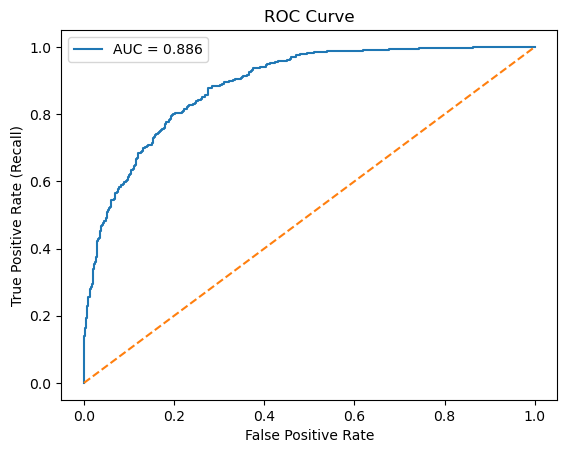

In [11]:
         # Making a visual representation of the ROC-AUC score

fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [12]:
        # Performing a cross-validation to assure no overfitting took place

models = {
    "lr": lr_pipe,
    "rf": rf_pipe,
    "xgb": xgb_pipe,
    "stack": stack
}

for name, model in models.items():
    score = cross_val_score(
        model,
        X, y,
        cv=5,
        scoring="average_precision",    # Use average_precision because churn is imbalanced and probability-based, not a simple binary decision.
        n_jobs=-1
    ).mean()

    print(name, '=', score)

lr = 0.6824387036683397
rf = 0.6405315998818161
xgb = 0.6419018157228675
stack = 0.686132611404482


In [13]:
         # Finding the threshold with the highest recall

proba = stack.predict_proba(X_test)[:, 1]

for t in np.arange(0.1, 0.6, 0.05):
    preds = (proba >= t).astype(int)
    r = recall_score(y_test, preds)
    p = precision_score(y_test, preds)
    print(f"t={t:.2f}  recall={r:.3f}  precision={p:.3f}")

best_recall = {"t": 0.20, "r": 0.877, "p": 0.530}

print(f"prediction with the highest recall and precision >50%: t={best_recall['t']:.2f}  recall={best_recall['r']:.3f}  precision={best_recall['p']:.3f}")

t=0.10  recall=0.949  precision=0.455
t=0.15  recall=0.904  precision=0.491
t=0.20  recall=0.877  precision=0.530
t=0.25  recall=0.824  precision=0.561
t=0.30  recall=0.797  precision=0.596
t=0.35  recall=0.741  precision=0.622
t=0.40  recall=0.698  precision=0.651
t=0.45  recall=0.650  precision=0.669
t=0.50  recall=0.588  precision=0.712
t=0.55  recall=0.527  precision=0.764
prediction with the highest recall and precision >50%: t=0.20  recall=0.877  precision=0.530


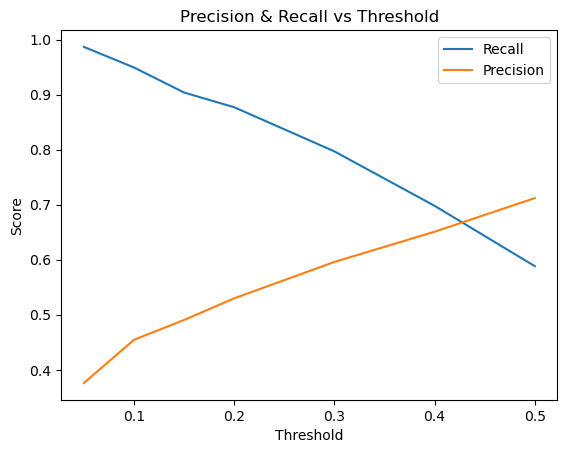

In [14]:
        # Visual representation of the highest recall (precision loss isn't as costly as recall loss... in churn)

precisions = []
recalls=[]
thresholds = [0.5, 0.4, 0.3, 0.2, 0.15, 0.1, 0.05]

for t in thresholds:
    preds = (y_proba >= t).astype(int)
    precisions.append(precision_score(y_test, preds))
    recalls.append(recall_score(y_test, preds))

plt.figure()
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, precisions, label="Precision")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision & Recall vs Threshold")
plt.show()

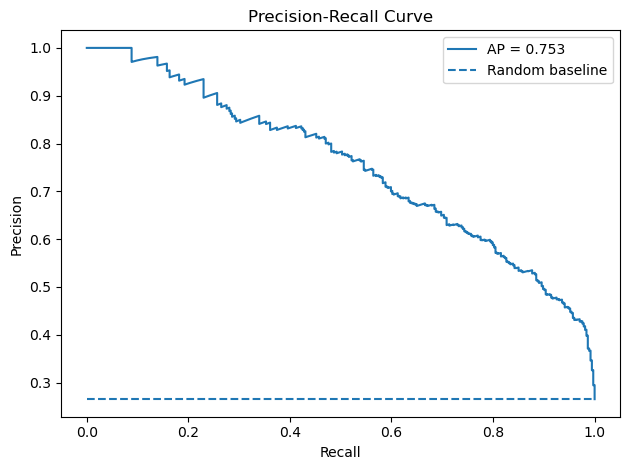

In [15]:
        # Visualizing a Precision-Recall Curve 

precision, recall, _ = precision_recall_curve(y_test, proba)
ap = average_precision_score(y_test, proba)

plt.figure()
plt.plot(recall, precision, label=f"AP = {ap:.3f}")

baseline = y_test.mean()
plt.hlines(baseline, 0, 1, linestyles="--", label="Random baseline")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()

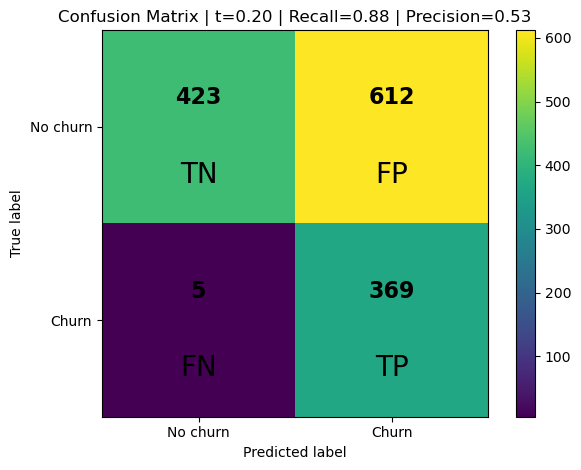

In [16]:
         #Visualizing confusion matrix

cm = confusion_matrix(y_test, preds)

disp = ConfusionMatrixDisplay(cm, display_labels=["No churn", "Churn"])
disp.plot(include_values=False)

labels = np.array([
    ["TN", "FP"],
    ["FN", "TP"]
])

for i in range(2):
    for j in range(2):
        plt.text(j, i-0.15, f"{cm[i, j]}",
                 ha="center", va="center",
                 fontsize=16, weight="bold")

        plt.text(j, i+0.25, labels[i, j],
                 ha="center", va="center",
                 fontsize=20)

r = recall_score(y_test, preds)
p = precision_score(y_test, preds)

plt.title(f"Confusion Matrix | t={best_recall['t']:.2f} | Recall={best_recall['r']:.2f} | Precision={best_recall['p']:.2f}")
plt.tight_layout()
plt.show()

In [17]:
         # Ranking the importance of the features

result = permutation_importance(
    stack, X_test, y_test,
    n_repeats=5,
    random_state=SEED,
    scoring="average_precision"    # Use average_precision because churn is imbalanced and probability-based, not a simple binary decision.
)                                  # It emphasizes correct ranking of high-risk customers and penalizes false positives.

# Transform to DataFrame

importance = pd.Series(result.importances_mean, index=X_test.columns)

print(importance.head(15).sort_values(ascending=False))

Tenure Months        0.116797
Contract             0.092609
Internet Service     0.069668
Dependents           0.059962
Online Security      0.023810
Tech Support         0.016399
Streaming TV         0.008616
Streaming Movies     0.006006
Multiple Lines       0.004923
Online Backup        0.003574
Partner              0.002711
Senior Citizen       0.001394
Gender               0.001144
Device Protection    0.000981
Phone Service       -0.002758
dtype: float64


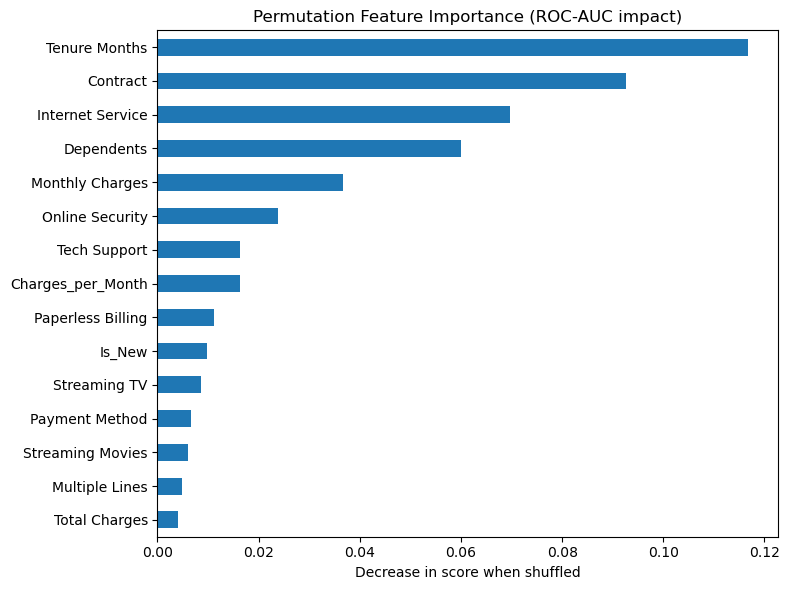

In [18]:
        # Visualizing feature importance

result = permutation_importance(
    stack, X_test, y_test,
    n_repeats=5,
    random_state=SEED,
    scoring="average_precision"    # Use average_precision because churn is imbalanced and probability-based, not a simple binary decision.
)

# convertir a dataframe
importance = pd.Series(result.importances_mean, index=X_test.columns).sort_values(ascending=False)

# graficar top 15
top_n = 15
plt.figure(figsize=(8,6))
importance.head(top_n).sort_values().plot(kind="barh")

plt.title("Permutation Feature Importance (ROC-AUC impact)")
plt.xlabel("Decrease in score when shuffled")
plt.tight_layout()
plt.show()